<a href="https://colab.research.google.com/github/Yuan-Yu-Han/PTAS/blob/main/machine_translation_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation using transformers: Overview

Transformers are a groundbreaking neural network architecture that has significantly advanced the field of natural language processing (NLP), particularly in sequence-to-sequence tasks. They've become the backbone of many modern NLP applications, including machine translation, text summarization, and language modeling.

A defining feature of transformers is their ability to process entire input sequences simultaneously. Unlike traditional recurrent models, which handle one token at a time, transformers leverage a self-attention mechanism to analyze relationships between all elements in a sequence at once. This enables the model to focus on relevant parts of the input context more efficiently and with greater flexibility.

In this tutorial, we'll explore how to build a machine translation system using the transformer architecture.



In [1]:
# ✅ Install required packages with compatible versions for PyTorch-based English-to-French translation.
# Includes torch (with GPU support), torchtext for dataset utilities, spaCy for tokenization,
# and tqdm for progress visualization.


# Remove torchtune (if exist)
!pip uninstall torchtune -y

# Reinstall compatible versions
!pip install torch==2.3.0 torchvision torchaudio
!pip install torchtext==0.18.0 torchdata
!pip install 'portalocker>=2.0.0' --no-deps
!pip install numpy==1.26.4


In [2]:
!pip install gputil

In [3]:
# Confirm the torch version

import torch

torch.__version__

'2.3.0+cu121'

### Loading The Data

In [4]:
import torchtext

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


##### Download the dataset

In [5]:
!pip install -U kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishreddy18/english-to-french")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'english-to-french' dataset.
Path to dataset files: /kaggle/input/english-to-french


In [6]:
en_df = pd.read_csv('/kaggle/input/english-to-french/small_vocab_en.csv', header=None, usecols=[0])
fr_df = pd.read_csv('/kaggle/input/english-to-french/small_vocab_fr.csv', header=None, usecols=[0])

english_sentences = en_df[0].astype(str).tolist()
french_sentences = fr_df[0].astype(str).tolist()

print(english_sentences[0:7])
print(french_sentences[0:7])


['new jersey is sometimes quiet during autumn ', 'the united states is usually chilly during july ', 'california is usually quiet during march ', 'the united states is sometimes mild during june ', 'your least liked fruit is the grape ', 'his favorite fruit is the orange ', 'paris is relaxing during december ']
["new jersey est parfois calme pendant l' automne ", 'les états-unis est généralement froid en juillet ', 'california est généralement calme en mars ', 'les états-unis est parfois légère en juin ', 'votre moins aimé fruit est le raisin ', "son fruit préféré est l'orange ", 'paris est relaxant en décembre ']


### Vocabulary Building and Sentence Encoding

This section defines helper functions and builds vocabularies for the English (source) and French (target) datasets.

1. **`yield_tokens`**: A generator function that tokenizes each sentence by lowercasing and splitting on spaces.
2. **Vocabulary Creation**:
   - Uses `build_vocab_from_iterator` to create source (`src_vocab`) and target (`trg_vocab`) vocabularies from tokenized English and French sentences.
   - Adds special tokens: `<pad>` for padding, `<sos>` (start of sentence), and `<eos>` (end of sentence).
   - Sets the default index to the padding token (`<pad>`), which is mapped to index 0.
3. **`encode_sentence`**:
   - Converts a raw sentence into a list of token indices using the corresponding vocabulary.
   - Optionally prepends `<sos>` and appends `<eos>` tokens for use in sequence models.
   - Returns the encoded sentence as a PyTorch tensor.


In [7]:
def yield_tokens(sentences):
    for sentence in sentences:
        yield sentence.strip().lower().split()

SRC_PAD_IDX = 0
TRG_PAD_IDX = 0

src_vocab = build_vocab_from_iterator(yield_tokens(english_sentences), specials=["<pad>", "<sos>", "<eos>"])
src_vocab.set_default_index(SRC_PAD_IDX) # if a token is not found in vocab set it to 0.

trg_vocab = build_vocab_from_iterator(yield_tokens(french_sentences), specials=["<pad>", "<sos>", "<eos>"])
trg_vocab.set_default_index(TRG_PAD_IDX) # if a token is not found in vocab set it to 0.

def encode_sentence(sentence, vocab, add_specials=True):
    tokens = sentence.lower().strip().split()
    if add_specials:
        tokens = ['<sos>'] + tokens + ['<eos>']
    return torch.tensor(vocab(tokens), dtype=torch.long)


### Custom Dataset and DataLoader for Machine Translation

This section defines a PyTorch-compatible dataset and a collate function to prepare batches for training a transformer-based translation model.

1. **`TranslationDataset` Class**:
   - Inherits from `torch.utils.data.Dataset`.
   - Takes lists of source (`src`) and target (`trg`) sentences along with their respective vocabularies.
   - Implements `__len__` and `__getitem__`:
     - `__getitem__` encodes each source and target sentence into tensors of token indices using `encode_sentence`.

2. **`collate_fn` Function**:
   - A custom function used to combine individual samples into a batch.
   - Uses `pad_sequence` to pad sequences in the batch so they have equal lengths.
   - Ensures correct padding values (`SRC_PAD_IDX` and `TRG_PAD_IDX`) are used for source and target batches.

3. **`DataLoader` Setup**:
   - Wraps the dataset in a `DataLoader` to enable efficient batch processing.
   - Shuffles data and uses the custom `collate_fn` to handle variable-length sequences.


In [8]:
class TranslationDataset(Dataset):
    def __init__(self, src, trg, src_vocab, trg_vocab):
        self.src = src
        self.trg = trg
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_seq = encode_sentence(self.src[idx], self.src_vocab)
        trg_seq = encode_sentence(self.trg[idx], self.trg_vocab)
        return src_seq, trg_seq

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=SRC_PAD_IDX) # pads the seq to be the same length as the longest sequence
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_PAD_IDX)
    return src_batch, trg_batch

dataset = TranslationDataset(english_sentences, french_sentences, src_vocab, trg_vocab)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


### Spit into train, val and test set.


In [9]:
from torch.utils.data import random_split

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Total size
dataset = TranslationDataset(english_sentences, french_sentences, src_vocab, trg_vocab)
total_size = len(dataset)

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


### Positional Encoding Module

This module adds **positional information** to input embeddings, enabling the transformer model to capture the order of tokens in a sequence.

- Uses **sine and cosine functions** of different frequencies to generate position-dependent vectors.
- Applies dropout for regularization.
- The positional encodings are **precomputed and stored** as a buffer to avoid recomputation during training.

The encoding is added to the input embeddings before they are passed into the transformer layers.


### Positional Encoding Formulas

For each position `pos` and embedding dimension `i`, the positional encoding is defined as:

- **Even dimensions** (i = 0, 2, 4, ...):

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

- **Odd dimensions** (i = 1, 3, 5, ...):

$$
PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

---

### What this means:

- Each position `pos` has a **unique encoding vector**
- Each dimension `i` corresponds to a **different frequency**
- Sine and cosine allow the model to **recover relative positions**


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pos_encoding = torch.zeros(max_len, d_model)
        positions = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term) # for all 2i
        pos_encoding[:, 1::2] = torch.cos(positions * div_term) # for all 2i + 1

        self.register_buffer('pe', pos_encoding.unsqueeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


### Sequence-to-Sequence Transformer Model

This class defines the core **Transformer-based encoder-decoder architecture** for sequence-to-sequence tasks such as machine translation.

Key components:
- **Embedding Layers**: Convert token indices from the source and target sequences into dense vector representations.
- **Positional Encoding**: Adds position information to the embeddings to help the model understand word order.
- **`nn.Transformer`**: The main transformer block containing multi-head attention, feedforward networks, and residual connections.
  - Configurable number of encoder and decoder layers.
- **Output Generator**: A linear layer that maps the transformer's output to the target vocabulary size for prediction.

The `forward` method takes:
- `src`, `tgt`: Source and target token sequences.
- `src_mask`, `tgt_mask`: Masks to prevent attention to future tokens or pad tokens.
- `src_padding_mask`, `tgt_padding_mask`: Masks to ignore padding in the attention mechanism.

It returns the output logits for the target sequence.


In [11]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, None)
        return self.generator(outs)


### Mask Generation for Transformer

Transformers require masks to control how tokens attend to one another during training, especially for tasks like language modeling and translation. This section defines two functions:

1. **`generate_square_subsequent_mask(sz)`**:
   - Creates an **upper triangular matrix** filled with `-inf` above the diagonal.
   - Prevents the decoder from attending to future tokens during training (auto-regressive behavior).

2. **`create_mask(src, tgt)`**:
   - Generates the necessary masks for both source and target sequences:
     - `src_mask`: A placeholder (all zeros) since the encoder attends to the full input.
     - `tgt_mask`: Prevents the decoder from peeking ahead using `generate_square_subsequent_mask`.
     - `src_padding_mask` and `tgt_padding_mask`: Identify padded positions in the input, so they can be ignored during attention computation.

These masks are passed to the transformer during training and inference to ensure correct attention behavior.


In [12]:
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1) # keeps the elements above main diagonal inf

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    # Ensure tgt_mask and src_mask are both bool type
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len).type(torch.bool) # mask future tokens (all -infs are True)
    src_mask = torch.zeros((src_seq_len, src_seq_len), dtype=torch.bool) # all tokens of src is known (all False)

    # Padding masks for src and tgt (batch, seq_len)
    src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1) # mask for pad tokens
    tgt_padding_mask = (tgt == TRG_PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


### Training

In [13]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Accuracy function
def calculate_accuracy(logits, target):
    pred = logits.argmax(dim=-1)
    non_pad = target != TRG_PAD_IDX
    correct = (pred == target) & non_pad
    return correct.sum().item() / non_pad.sum().item()

# Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SRC_PAD_IDX = src_vocab['<pad>']
SRC_SOS_IDX = src_vocab['<sos>']
SRC_EOS_IDX = src_vocab['<eos>']

TRG_PAD_IDX = trg_vocab['<pad>']
TRG_SOS_IDX = trg_vocab['<sos>']
TRG_EOS_IDX = trg_vocab['<eos>']

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(trg_vocab)
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
BATCH_SIZE = 32
NUM_EPOCHS = 3

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                           NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM).to(DEVICE)

loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

itos = trg_vocab.get_itos()
smoothie = SmoothingFunction().method4 # this is for blue score

# 📊 记录训练历史用于可视化
history = {
    'train_loss': [], 'train_acc': [], 'train_bleu': [],
    'val_loss': [], 'val_acc': [], 'val_bleu': []
}

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0
    total_bleu = 0
    total_samples = 0

    for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]  # remove <eos>
        tgt_out = tgt[1:, :]     # remove <sos>

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask.to(DEVICE), tgt_mask.to(DEVICE),
                       src_pad_mask.to(DEVICE), tgt_pad_mask.to(DEVICE))

        optimizer.zero_grad()
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += calculate_accuracy(logits, tgt_out)

        pred_tokens = logits.argmax(-1).transpose(0, 1).tolist()
        target_tokens = tgt_out.transpose(0, 1).tolist()

        for pred, ref in zip(pred_tokens, target_tokens):
            pred_clean = [itos[tok] for tok in pred if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            ref_clean = [itos[tok] for tok in ref if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            if len(ref_clean) > 0 and len(pred_clean) > 0:
                bleu = sentence_bleu([ref_clean], pred_clean, smoothing_function=smoothie)
                total_bleu += bleu
                total_samples += 1

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    avg_train_bleu = (total_bleu / total_samples) * 100 if total_samples > 0 else 0

    # ------------------ Validation -------------------
    model.eval()
    val_loss, val_acc = 0, 0
    val_bleu = 0
    val_samples = 0

    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            tgt_input = tgt[:-1, :]
            tgt_out = tgt[1:, :]

            src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask.to(DEVICE), tgt_mask.to(DEVICE),
                           src_pad_mask.to(DEVICE), tgt_pad_mask.to(DEVICE))

            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            val_loss += loss.item()
            val_acc += calculate_accuracy(logits, tgt_out)

            pred_tokens = logits.argmax(-1).transpose(0, 1).tolist()
            target_tokens = tgt_out.transpose(0, 1).tolist()

            for pred, ref in zip(pred_tokens, target_tokens):
                pred_clean = [itos[tok] for tok in pred if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
                ref_clean = [itos[tok] for tok in ref if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
                if len(ref_clean) > 0 and len(pred_clean) > 0:
                    bleu = sentence_bleu([ref_clean], pred_clean, smoothing_function=smoothie)
                    val_bleu += bleu
                    val_samples += 1

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    avg_val_bleu = (val_bleu / val_samples) * 100 if val_samples > 0 else 0

    # 📊 保存历史记录
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['train_bleu'].append(avg_train_bleu)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)
    history['val_bleu'].append(avg_val_bleu)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss = {avg_train_loss:.4f}, Train Acc = {avg_train_acc:.4f}, Train BLEU = {avg_train_bleu:.2f}")
    print(f"  Val   Loss = {avg_val_loss:.4f}, Val   Acc = {avg_val_acc:.4f}, Val   BLEU = {avg_val_bleu:.2f}")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1 - Val: 100%|██████████| 431/431 [00:06<00:00, 70.20it/s] 


Epoch 1:
  Train Loss = 0.4649, Train Acc = 0.9025, Train BLEU = 77.27
  Val   Loss = 0.0788, Val   Acc = 0.9757, Val   BLEU = 89.92


Epoch 2 - Val: 100%|██████████| 431/431 [00:04<00:00, 95.18it/s]


Epoch 2:
  Train Loss = 0.0818, Train Acc = 0.9752, Train BLEU = 89.89
  Val   Loss = 0.0510, Val   Acc = 0.9826, Val   BLEU = 91.94


Epoch 3 - Val: 100%|██████████| 431/431 [00:04<00:00, 100.87it/s]

Epoch 3:
  Train Loss = 0.0578, Train Acc = 0.9808, Train BLEU = 91.24
  Val   Loss = 0.0410, Val   Acc = 0.9857, Val   BLEU = 92.55


/tmp/ipython-input-4115610765.py:33: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4115610765.py:33: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4115610765.py:33: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

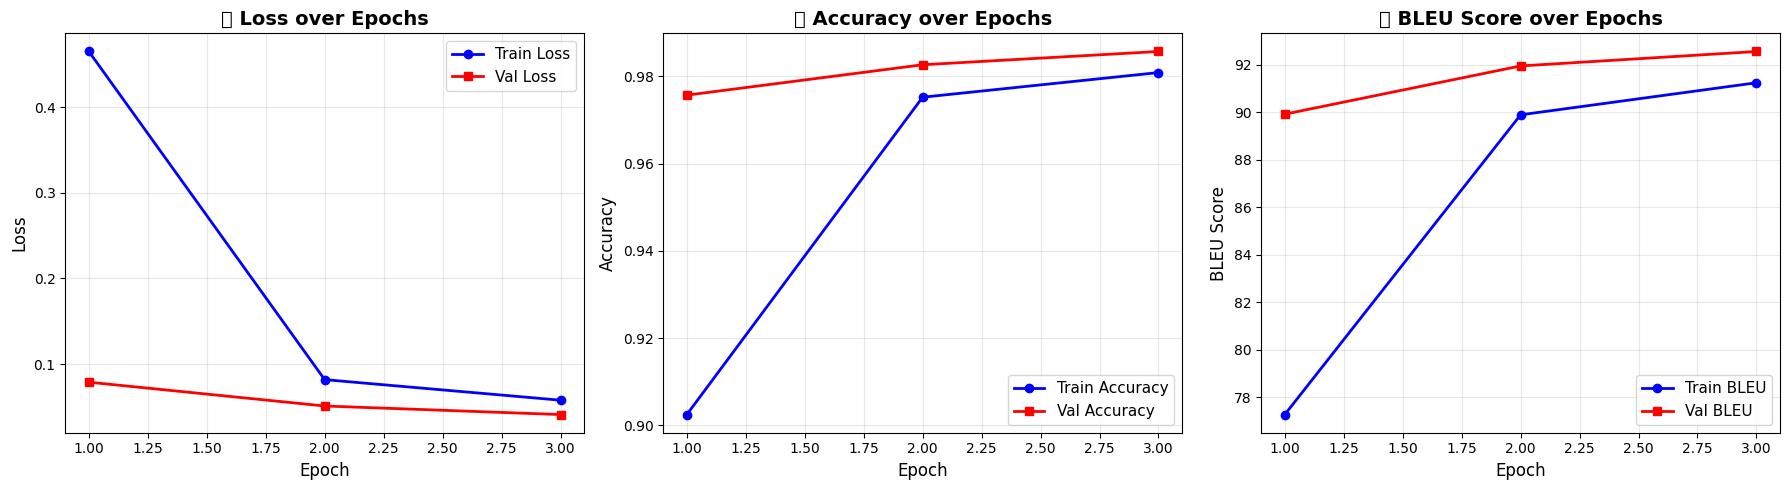


📊 FINAL TRAINING STATISTICS
Best Train Loss: 0.0578 at Epoch 3
Best Val Loss:   0.0410 at Epoch 3
Best Train Acc:  0.9808 at Epoch 3
Best Val Acc:    0.9857 at Epoch 3
Best Train BLEU: 91.24 at Epoch 3
Best Val BLEU:   92.55 at Epoch 3


In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
epochs = range(1, NUM_EPOCHS + 1)
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('📉 Loss over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('🎯 Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# BLEU Score
axes[2].plot(epochs, history['train_bleu'], 'b-o', label='Train BLEU', linewidth=2)
axes[2].plot(epochs, history['val_bleu'], 'r-s', label='Val BLEU', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('BLEU Score', fontsize=12)
axes[2].set_title('✨ BLEU Score over Epochs', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印最终统计
print("\n" + "="*60)
print("📊 FINAL TRAINING STATISTICS")
print("="*60)
print(f"Best Train Loss: {min(history['train_loss']):.4f} at Epoch {history['train_loss'].index(min(history['train_loss']))+1}")
print(f"Best Val Loss:   {min(history['val_loss']):.4f} at Epoch {history['val_loss'].index(min(history['val_loss']))+1}")
print(f"Best Train Acc:  {max(history['train_acc']):.4f} at Epoch {history['train_acc'].index(max(history['train_acc']))+1}")
print(f"Best Val Acc:    {max(history['val_acc']):.4f} at Epoch {history['val_acc'].index(max(history['val_acc']))+1}")
print(f"Best Train BLEU: {max(history['train_bleu']):.2f} at Epoch {history['train_bleu'].index(max(history['train_bleu']))+1}")
print(f"Best Val BLEU:   {max(history['val_bleu']):.2f} at Epoch {history['val_bleu'].index(max(history['val_bleu']))+1}")
print("="*60)


### 📊 Training Visualization

Visualize the training progress with loss, accuracy, and BLEU score curves.


### Evaluation on test set

In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

itos = trg_vocab.get_itos()

# Test evaluation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model.eval()
test_loss, test_acc = 0, 0
total_bleu = 0
total_samples = 0

with torch.no_grad():
    for src, tgt in tqdm(test_loader, desc="Test Set"):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        tgt_out = tgt[1:, :]

        src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask.to(DEVICE), tgt_mask.to(DEVICE),
                       src_pad_mask.to(DEVICE), tgt_pad_mask.to(DEVICE))

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        test_loss += loss.item()
        test_acc += calculate_accuracy(logits, tgt_out)

        # BLEU computation
        pred_tokens = logits.argmax(-1).transpose(0, 1).tolist()
        target_tokens = tgt_out.transpose(0, 1).tolist()

        for pred, ref in zip(pred_tokens, target_tokens):
            pred_clean = [itos[tok] for tok in pred if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            ref_clean = [itos[tok] for tok in ref if tok not in {TRG_PAD_IDX, TRG_SOS_IDX, TRG_EOS_IDX}]
            if len(ref_clean) > 0 and len(pred_clean) > 0:
                bleu = sentence_bleu([ref_clean], pred_clean, smoothing_function=smoothie)
                total_bleu += bleu
                total_samples += 1

avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader)
avg_test_bleu = (total_bleu / total_samples) * 100 if total_samples > 0 else 0

print(f"\n📊 Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}, Test BLEU: {avg_test_bleu:.2f}")


Test Set: 100%|██████████| 431/431 [00:04<00:00, 93.03it/s]


📊 Test Loss: 0.0400, Test Accuracy: 0.9860, Test BLEU: 92.67


/tmp/ipython-input-829794761.py:33: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


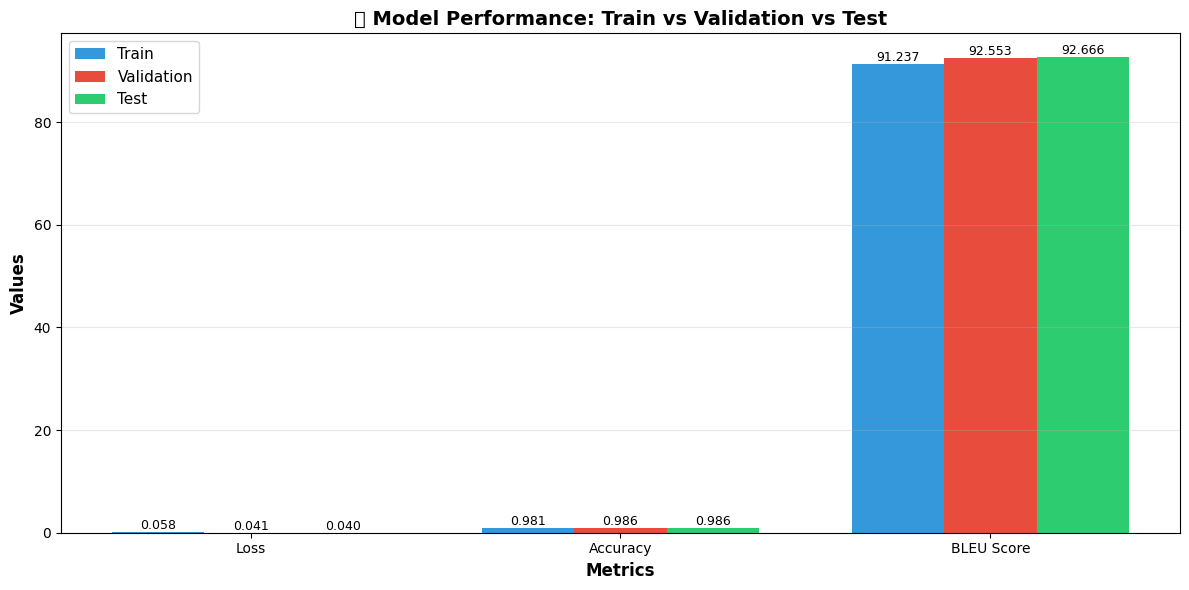

In [16]:
import matplotlib.pyplot as plt

# 创建对比图表
metrics = ['Loss', 'Accuracy', 'BLEU Score']
train_values = [history['train_loss'][-1], history['train_acc'][-1], history['train_bleu'][-1]]
val_values = [history['val_loss'][-1], history['val_acc'][-1], history['val_bleu'][-1]]
test_values = [avg_test_loss, avg_test_acc, avg_test_bleu]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, train_values, width, label='Train', color='#3498db')
bars2 = ax.bar(x, val_values, width, label='Validation', color='#e74c3c')
bars3 = ax.bar(x + width, test_values, width, label='Test', color='#2ecc71')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Values', fontsize=12, fontweight='bold')
ax.set_title('🎯 Model Performance: Train vs Validation vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# 在柱子上添加数值
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 📊 Test Set Performance Visualization


### Checking on samples from test set

In [17]:
def translate(model, sentence):
    model.eval()
    src = encode_sentence(sentence, src_vocab).unsqueeze(1).to(DEVICE)
    num_tokens = src.shape[0]
    src_mask = torch.zeros((num_tokens, num_tokens)).type(torch.bool).to(DEVICE)

    memory = model.transformer.encoder(model.positional_encoding(model.src_tok_emb(src)), src_mask)
    ys = torch.tensor([[trg_vocab['<sos>']]], dtype=torch.long).to(DEVICE)

    for i in range(50):
        tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(DEVICE)
        out = model.transformer.decoder(model.positional_encoding(model.tgt_tok_emb(ys)), memory, tgt_mask)
        out = model.generator(out)
        next_word = out[-1, 0].argmax().item()
        ys = torch.cat([ys, torch.tensor([[next_word]], device=DEVICE)], dim=0)
        if next_word == trg_vocab['<eos>']:
            break

    translated = [trg_vocab.get_itos()[token] for token in ys.squeeze()][1:-1]
    return ' '.join(translated)


In [18]:
print("\n" + "="*80)
print("🔍 DETAILED TEST SET SAMPLES (10 Examples)")
print("="*80 + "\n")

num_samples = min(10, len(test_dataset))

for i in range(num_samples):
    src_sentence = test_dataset[i][0]
    tgt_sentence = test_dataset[i][1]

    # Decode token IDs back to words using vocab
    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok != SRC_PAD_IDX])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok] for tok in tgt_sentence if tok != TRG_PAD_IDX])
    predicted_text = translate(model, src_text)

    # 计算单个BLEU分数
    pred_tokens = predicted_text.split()
    ref_tokens = [tok for tok in tgt_text.split() if tok not in ['<sos>', '<eos>']]

    if len(ref_tokens) > 0 and len(pred_tokens) > 0:
        bleu_score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
    else:
        bleu_score = 0.0

    print(f"{'─' * 80}")
    print(f"Sample {i+1}:")
    print(f"  📝 English:           {src_text}")
    print(f"  🤖 Predicted French:  {predicted_text}")
    print(f"  ✅ Ground Truth:      {tgt_text}")
    print(f"  📊 BLEU Score:        {bleu_score:.2f}")
    print()

print("="*80)



🔍 DETAILED TEST SET SAMPLES (10 Examples)

────────────────────────────────────────────────────────────────────────────────
Sample 1:
  📝 English:           <sos> the lemon is their least liked fruit <eos>
  🤖 Predicted French:  le citron est leur fruit moins aimé
  ✅ Ground Truth:      <sos> le citron est leur fruit moins aimé <eos>
  📊 BLEU Score:        100.00

────────────────────────────────────────────────────────────────────────────────
Sample 2:
  📝 English:           <sos> i dislike limes <eos>
  🤖 Predicted French:  je n'aime pas citrons verts et les citrons verts .
  ✅ Ground Truth:      <sos> je n'aime pas citrons verts <eos>
  📊 BLEU Score:        39.28

────────────────────────────────────────────────────────────────────────────────
Sample 3:
  📝 English:           <sos> china is usually rainy during april <eos>
  🤖 Predicted French:  chine est généralement pluvieux en avril
  ✅ Ground Truth:      <sos> chine est généralement pluvieux en avril <eos>
  📊 BLEU Score:      

In [22]:
# 找出最好和最差的翻译
num_analysis_samples = len(test_dataset)
bleu_scores = []

print(f"🔍 Calculating BLEU scores for {num_analysis_samples} test samples...")

for i in tqdm(range(num_analysis_samples), desc="Computing BLEU scores"): # Added tqdm for progress visualization
    src_sentence = test_dataset[i][0]
    tgt_sentence = test_dataset[i][1]

    # Decode token IDs back to words using vocab
    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])
    # The ground truth `tgt_text` should include <sos> and <eos> for translation but not for BLEU calculation
    # The translate function expects input without <sos> and <eos> and adds them internally.

    predicted_text = translate(model, src_text)

    # Prepare target tokens for BLEU calculation (without special tokens)
    # The `tgt_sentence` from `test_dataset` contains <sos> and <eos> as it's an encoded tensor.
    # We need to convert it to actual words and remove special tokens for comparison.
    ref_tokens_with_specials = [trg_vocab.get_itos()[tok.item()] for tok in tgt_sentence]
    ref_tokens = [tok for tok in ref_tokens_with_specials if tok not in {trg_vocab.get_itos()[TRG_PAD_IDX], trg_vocab.get_itos()[TRG_SOS_IDX], trg_vocab.get_itos()[TRG_EOS_IDX]}]

    pred_tokens = predicted_text.split()

    if len(ref_tokens) > 0 and len(pred_tokens) > 0:
        bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
    else:
        bleu = 0.0
    bleu_scores.append(bleu)

bleu_with_idx = [(i, score) for i, score in enumerate(bleu_scores)]
bleu_with_idx.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*80)
print("🏆 TOP 5 BEST TRANSLATIONS")
print("="*80 + "\n")

for rank, (idx, bleu) in enumerate(bleu_with_idx[:5], 1):
    src_sentence = test_dataset[idx][0]
    tgt_sentence = test_dataset[idx][1]

    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok.item()] for tok in tgt_sentence if tok not in {TRG_PAD_IDX}]) # Used .item() for tensor elements
    predicted_text = translate(model, src_text)

    print(f"#{rank} - BLEU Score: {bleu:.2f}")
    print(f"  📝 English:           {src_text}")
    print(f"  🤖 Predicted French:  {predicted_text}")
    print(f"  ✅ Ground Truth:      {tgt_text}")
    print()

print("\n" + "="*80)
print("⚠️  TOP 5 WORST TRANSLATIONS")
print("="*80 + "\n")

for rank, (idx, bleu) in enumerate(bleu_with_idx[-5:][::-1], 1):
    src_sentence = test_dataset[idx][0]
    tgt_sentence = test_dataset[idx][1]

    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok not in {SRC_PAD_IDX, SRC_SOS_IDX, SRC_EOS_IDX}])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok.item()] for tok in tgt_sentence if tok not in {TRG_PAD_IDX}]) # Used .item() for tensor elements
    predicted_text = translate(model, src_text)

    print(f"#{rank} - BLEU Score: {bleu:.2f}")
    print(f"  📝 English:           {src_text}")
    print(f"  🤖 Predicted French:  {predicted_text}")
    print(f"  ✅ Ground Truth:      {tgt_text}")
    print()

print("="*80)

🔍 Calculating BLEU scores for 13786 test samples...


Computing BLEU scores: 100%|██████████| 13786/13786 [08:12<00:00, 27.97it/s]



🏆 TOP 5 BEST TRANSLATIONS

#1 - BLEU Score: 100.00
  📝 English:           <sos> the lemon is their least liked fruit <eos>
  🤖 Predicted French:  le citron est leur fruit moins aimé
  ✅ Ground Truth:      <sos> le citron est leur fruit moins aimé <eos>

#2 - BLEU Score: 100.00
  📝 English:           <sos> china is usually rainy during april <eos>
  🤖 Predicted French:  chine est généralement pluvieux en avril
  ✅ Ground Truth:      <sos> chine est généralement pluvieux en avril <eos>

#3 - BLEU Score: 100.00
  📝 English:           <sos> paris is never rainy during june <eos>
  🤖 Predicted French:  paris est jamais pluvieux en juin
  ✅ Ground Truth:      <sos> paris est jamais pluvieux en juin <eos>

#4 - BLEU Score: 100.00
  📝 English:           <sos> france is quiet during november <eos>
  🤖 Predicted French:  france est calme en novembre
  ✅ Ground Truth:      <sos> france est calme en novembre <eos>

#5 - BLEU Score: 100.00
  📝 English:           <sos> new jersey is never nice duri

### 🎯 Best and Worst Translations


🔍 Analyzing BLEU scores for 100 test samples...



Computing BLEU scores: 100%|██████████| 100/100 [00:03<00:00, 29.31it/s]
/tmp/ipython-input-3228997059.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3228997059.py:43: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


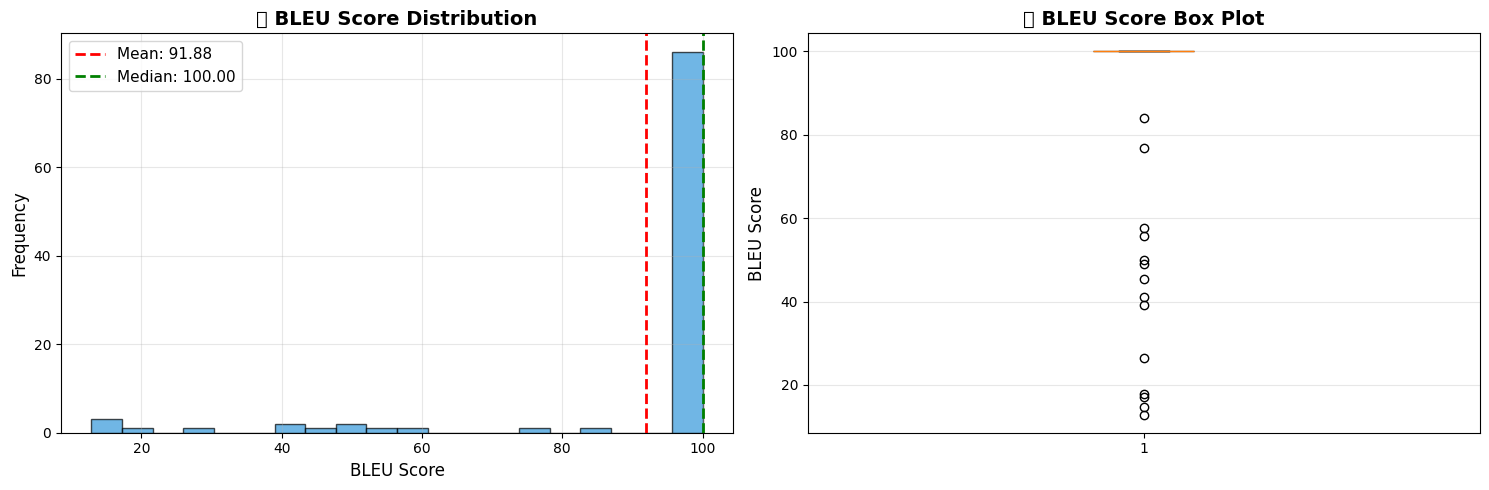


📊 BLEU SCORE STATISTICS
Mean BLEU Score:     91.88
Median BLEU Score:   100.00
Std Dev:             21.70
Min BLEU Score:      12.87
Max BLEU Score:      100.00
25th Percentile:     100.00
75th Percentile:     100.00


In [23]:
# 计算更多测试样本的BLEU分数分布
num_analysis_samples = min(100, len(test_dataset))
bleu_scores = []

print(f"🔍 Analyzing BLEU scores for {num_analysis_samples} test samples...\n")

for i in tqdm(range(num_analysis_samples), desc="Computing BLEU scores"):
    src_sentence = test_dataset[i][0]
    tgt_sentence = test_dataset[i][1]

    src_text = ' '.join([src_vocab.get_itos()[tok] for tok in src_sentence if tok != SRC_PAD_IDX])
    tgt_text = ' '.join([trg_vocab.get_itos()[tok] for tok in tgt_sentence if tok != TRG_PAD_IDX])
    predicted_text = translate(model, src_text)

    pred_tokens = predicted_text.split()
    ref_tokens = [tok for tok in tgt_text.split() if tok not in ['<sos>', '<eos>']]

    if len(ref_tokens) > 0 and len(pred_tokens) > 0:
        bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie) * 100
        bleu_scores.append(bleu)

# 可视化BLEU分数分布
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 直方图
axes[0].hist(bleu_scores, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(bleu_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(bleu_scores):.2f}')
axes[0].axvline(np.median(bleu_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(bleu_scores):.2f}')
axes[0].set_xlabel('BLEU Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('📊 BLEU Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 箱线图
box = axes[1].boxplot(bleu_scores, vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('#2ecc71')
box['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('BLEU Score', fontsize=12)
axes[1].set_title('📦 BLEU Score Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 打印统计信息
print("\n" + "="*60)
print("📊 BLEU SCORE STATISTICS")
print("="*60)
print(f"Mean BLEU Score:     {np.mean(bleu_scores):.2f}")
print(f"Median BLEU Score:   {np.median(bleu_scores):.2f}")
print(f"Std Dev:             {np.std(bleu_scores):.2f}")
print(f"Min BLEU Score:      {np.min(bleu_scores):.2f}")
print(f"Max BLEU Score:      {np.max(bleu_scores):.2f}")
print(f"25th Percentile:     {np.percentile(bleu_scores, 25):.2f}")
print(f"75th Percentile:     {np.percentile(bleu_scores, 75):.2f}")
print("="*60)


### 📈 BLEU Score Distribution Analysis


####
To-Do

Q. Visualize results for other samples from the test set

Q. Try different epoch values — e.g., 4, 5, 6 — and observe how the loss changes.

Q. Experiment with different architecture configurations, such as changing the number of encoder and decoder layers.

Q. Try for different batch sizes

Q. We you find a different translation dataset try on that.

### Resources

[The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)


### [Quiz](https://docs.google.com/forms/d/e/1FAIpQLScM0wn9cLVWCQvJemeOWlrK_RhGBmdeKOJBaqFkERFGmyqK3w/viewform?usp=dialog)